<a href="https://colab.research.google.com/github/Mainakdeb/project-jurkat/blob/main/project-jurkat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work in progress

In [2]:
!pip install iterative-stratification

In [ ]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip
!wget https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst
!unzip "/content/BBBC048v1.zip"
!unzip "/content/CellCycle.zip"

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from albumentations import *
import torchvision.transforms as transforms
from tqdm.notebook import tnrange, tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torchvision import models 
import torch.nn as nn
import torch.optim as optim
import time
import seaborn as sns
import os, csv

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
dataframe1 = pd.read_csv("/content/Ground_truth.lst",
                          header=None) 

In [8]:
#generate csv
cell_df = pd.DataFrame(list())
cell_df.to_csv('cell_cycle.csv')

f=open("cell_cycle.csv",'r+')
w=csv.writer(f)

folders = ["Anaphase", "G1", "G2","Metaphase", "Prophase", "S", "Telophase"]
folders2 = ["G1","G2","S"]

for f in folders2:
  for path, dirs, files in os.walk("/content/CellCycle/"+f+"/"):
      for filename in files:
          w.writerow([path+filename, f])


In [9]:
#name columns
c = pd.read_csv('./cell_cycle.csv', header=None)
c.columns = ["path","class_name"]
print("class names: ",c.class_name.unique())

#delete non merged rows
c_merged=c[c.path.str[-10:] == "merged.jpg"]
c_merged.to_csv("cell_merged.csv")

class names:  ['G1' 'G2' 'S']


In [10]:
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [11]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'G1':0,
                           'S': 1,
                           'G2':2}
        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][1]) #image path column
        class_name = str(self.d.iloc[idx][2])  #class name column
        full_img_path = self.root_dir + smol_img_path #+ '.png'
        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]

        if self.transform is not None:
            img_ret = self.transform(img2)
        
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }

    def __len__(self):
        return (len(self.d))

In [12]:
data = C_Dataset(pd.read_csv('/content/cell_merged.csv'), 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

train_dl = torch.utils.data.DataLoader(data,
                                       batch_size=64,
                                       shuffle=True,
                                       #pin_memory=True,
                                       #num_workers=4
                                    )

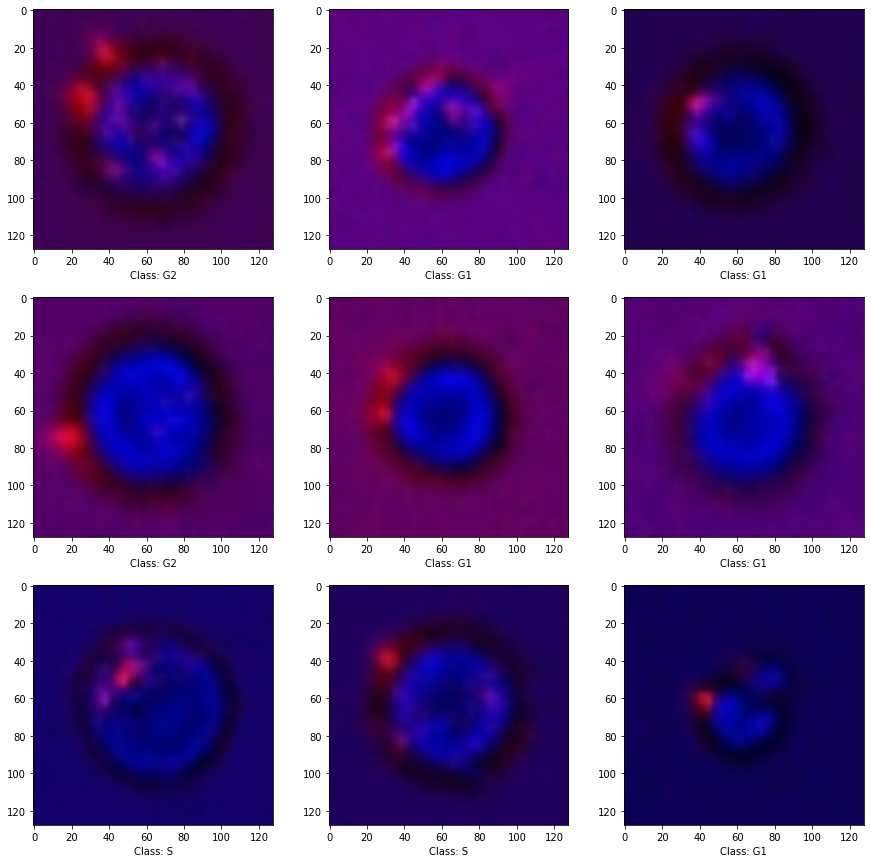

In [13]:
#plot samples from dataloader
fig, ax = plt.subplots(3,3, figsize = (15,15))
class_dict = {'G1':0,
              'S': 1,
              'G2':2}

for i in range (9):
  batch = next(iter(train_dl))
  image, label=batch['x'],batch['y']
  #print(label)
  ax.flat[i].imshow(image[0].permute(1,2,0))
  
  text = "Class: "+list(class_dict.keys())[int(label[0])]
  ax.flat[i].set_xlabel(text)

In [18]:
#create a subset
df = pd.read_csv('/content/cell_merged.csv')
df = df.sample(frac=1)
# iloc[row slicing, column slicing]
subset_df = df.iloc[0:10000, 1:]
subset_df.to_csv("cell_merged_subset.csv")

In [19]:
#create folds
df = pd.read_csv('/content/cell_merged_subset.csv')
df.loc[:,"kfold"] = -1
targets = df.drop("class_name", axis=1).values

NFOLDS = 10
mskf = MultilabelStratifiedKFold(n_splits = NFOLDS)
for fold, (trn, val) in enumerate(mskf.split(X=df, y = targets)):
    df.loc[val, "kfold"] = fold
    
df.to_csv("./train_targets_folds.csv", index=False)
train_csv = pd.read_csv('./train_targets_folds.csv')
train_csv.head()

,Unnamed: 0,path,class_name,kfold
0,20293,/content/CellCycle/G2/15000_merged.jpg,G2,9
1,7454,/content/CellCycle/G1/10945_merged.jpg,G1,0
2,21217,/content/CellCycle/G2/8360_merged.jpg,G2,3
3,26011,/content/CellCycle/S/36307_merged.jpg,S,7
4,12608,/content/CellCycle/G1/32275_merged.jpg,G1,4


In [20]:
class Engine:
      def __init__(self, model, optimizer, device, scheduler, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion=criterion

      def train(self, data_loader):
        train_loss = 0.0
        valid_loss = 0.0
        total_tr = 0.0
        correct_tr = 0.0
        self.model.train()
        for batch in tqdm(data_loader):##
          data, target=batch['x'].to(self.device), batch['y'].to(self.device)
          self.optimizer.zero_grad()
          # Forward Pass
          output = self.model(data)
          loss = self.criterion(output, target)
          # Backward Pass  
          loss.backward()
          # Update loss and accuracy
          self.optimizer.step()
          train_loss += loss.item() * data.size(0)
          _,predicted = torch.max(output.data, 1)
          total_tr += target.size(0)
          correct_tr += (predicted == target).sum().item()
        #self.scheduler.step(1.)
        return(train_loss/len(data_loader.sampler), 100*correct_tr/total_tr)

      def evaluate(self, data_loader):
        #fix this
        self.model.eval()
        final_loss=0
        for data in data_loader:
            #self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(targets, outputs)
            #loss.backward()
            #self.optimizer.step()
            final_loss += loss.item()
        return(final_loss)


In [23]:
def run_training(fold, batch_size, lr, save_model=True, num_epochs = 1):

    val_fold=train_csv[train_csv['kfold'] == fold]
    train_fold=train_csv[train_csv['kfold'] != fold]
    
    
    train_dataset = C_Dataset(train_fold, 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )
    valid_dataset = C_Dataset(val_fold, 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )
    
    train_loader = torch.utils.data.DataLoader(
                    train_dataset
                    ,batch_size=batch_size
                    ,shuffle=True
                )

    val_loader = torch.utils.data.DataLoader(
                    valid_dataset
                    ,batch_size=32
                    ,shuffle=True
                )

    torch.cuda.empty_cache()
    model_ft = models.resnet101(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 3))
    model = model_ft.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.00001)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1,
                                                 patience=7, 
                                                 eps=1e-4, 
                                                 verbose=True)
    eng = Engine(model,
                 optimizer, 
                 device='cuda', 
                 scheduler = scheduler,
                 criterion=criterion)
    
    best_loss = 999
    early_stop_iter = 10
    early_stop_count=0

    for epoch in tnrange(num_epochs):
        train_loss, train_accuracy = eng.train(train_loader)
        #valid_loss = eng.evaluate(val_loader)
        print("train_loss: {:.4f} train_acc: {:.4f}".format(train_loss, train_accuracy))#, "val_loss:", valid_loss)
        #print(tot)
        # if valid_loss<best_loss:
        #     best_loss = valid_loss
        #     if save_model:
        #         torch.save(model.state_dict(), "model_"+str(fold)+".pth")
        # else:
        #     early_stop_count +=1
            
        # if early_stop_count>early_stop_iter:
        #     break
    torch.save(model.state_dict(), "model_last.pth")                
    return(best_loss)
    #to do: accuracy

In [24]:
best_losses = []
#train one fold
for fold in range(NFOLDS):
    best_losses.append(
        run_training(
            fold=fold,
            batch_size = 32,#best_params["batch_size"],
            lr = 0.0001,#best_params["lr"],
            num_epochs = 30
        )
    )
    break


train_loss: 1.0712 train_acc: 50.0444



train_loss: 0.8023 train_acc: 64.8889



train_loss: 0.7116 train_acc: 68.8889



train_loss: 0.6712 train_acc: 70.6889



train_loss: 0.6415 train_acc: 71.8333



train_loss: 0.6025 train_acc: 73.4222



train_loss: 0.5721 train_acc: 74.6444



train_loss: 0.5598 train_acc: 75.5444



train_loss: 0.5439 train_acc: 76.4778



train_loss: 0.5261 train_acc: 77.3778



train_loss: 0.5145 train_acc: 77.4222



train_loss: 0.5077 train_acc: 77.8889



train_loss: 0.4885 train_acc: 78.4333



train_loss: 0.4912 train_acc: 78.6556



train_loss: 0.4807 train_acc: 79.1111



train_loss: 0.4658 train_acc: 79.7889



train_loss: 0.4669 train_acc: 79.7778



train_loss: 0.4537 train_acc: 80.0556



train_loss: 0.4446 train_acc: 80.7667



train_loss: 0.4481 train_acc: 80.9222



train_loss: 0.4254 train_acc: 81.7444



train_loss: 0.4315 train_acc: 81.3556



train_loss: 0.4140 train_acc: 82.1889



train_loss: 0.4229 train_acc: 82.0556



train_loss: 0.3981 train_acc: 82.7889



train_loss: 0.3927 train_acc: 83.3333



train_loss: 0.3901 train_acc: 83.2778



train_loss: 0.3832 train_acc: 83.8333



train_loss: 0.3585 train_acc: 84.9556



train_loss: 0.3647 train_acc: 84.8778



In [25]:
data_sub = C_Dataset(pd.read_csv('/content/cell_merged_subset.csv'), 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

train_dl_sub = torch.utils.data.DataLoader(
    data_sub
    ,batch_size=64
    ,shuffle=True
    # ,pin_memory=True
    # ,num_workers=4
)

In [28]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 3))
model = model_ft.to(device)
model.load_state_dict(torch.load("model_last.pth"))

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


<All keys matched successfully>

Text(0.5, 37.77777777777778, 'Predicted label')

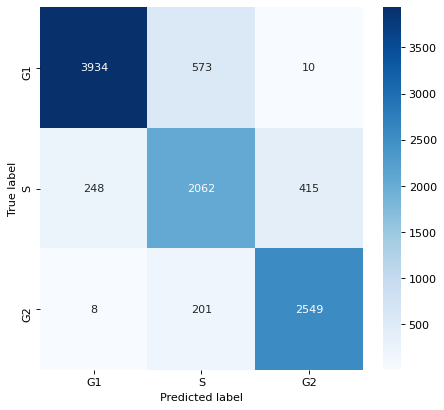

In [29]:
class_names =  ['G1', 'S', 'G2']
confusion_matrix = torch.zeros(len(class_names), len(class_names))

with torch.no_grad():
    for i, data in enumerate(train_dl_sub, 0):
        images, labels = data['x'], data['y']
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

cm = confusion_matrix.numpy()
fig = plt.figure(figsize=(6.5,6),  dpi = 80)
ax = sns.heatmap(cm,
                 annot=True, 
                 cmap='Blues', 
                 xticklabels = class_names, 
                 yticklabels = class_names, 
                 fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [30]:
#!cp /content/model_last.pth /content/drive/MyDrive/models/jurkat/